<a href="https://colab.research.google.com/github/dxdiag20/PUBG_Finish_Placement_Prediction/blob/master/pubg_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 245kB 6.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [6]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/

In [21]:
!kaggle competitions download -c pubg-finish-placement-prediction
!ls -al

 30% 5.00M/16.9M [00:00<00:00, 17.2MB/s]
100% 16.9M/16.9M [00:00<00:00, 50.7MB/s]
 92% 90.0M/98.3M [00:01<00:00, 58.2MB/s]
100% 98.3M/98.3M [00:01<00:00, 98.5MB/s]
 97% 233M/239M [00:02<00:00, 112MB/s]
100% 239M/239M [00:02<00:00, 122MB/s]
total 362704
drwxr-xr-x 1 root root      4096 Dec  4 16:08 .
drwxr-xr-x 1 root root      4096 Dec  4 16:01 ..
-rw-r--r-- 1 root root      2511 Dec  4 16:03 adc.json
drwxr-xr-x 1 root root      4096 Dec  4 16:03 .config
drwxr-xr-x 2 root root      4096 Dec  4 16:03 .kaggle
drwxr-xr-x 2 root root      4096 Nov 29 18:21 sample_data
-rw-r--r-- 1 root root  17688220 Dec  4 16:08 sample_submission_V2.csv.zip
-rw-r--r-- 1 root root 103060373 Dec  4 16:08 test_V2.csv.zip
-rw-r--r-- 1 root root 250618121 Dec  4 16:08 train_V2.csv.zip


In [22]:
!unzip train_V2.csv.zip

Archive:  train_V2.csv.zip
  inflating: train_V2.csv            


In [23]:
!unzip test_V2.csv.zip

Archive:  test_V2.csv.zip
  inflating: test_V2.csv             


In [2]:
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Nov 29 18:21 .
drwxr-xr-x 1 root root 4096 Dec  4 16:01 ..
drwxr-xr-x 1 root root 4096 Nov 29 18:21 .config
drwxr-xr-x 2 root root 4096 Nov 29 18:21 sample_data


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df_train = pd.read_csv('/content/train_V2.csv', header=0, sep=',', quotechar='"')

In [26]:
pd.set_option('display.max_columns', 100)
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [27]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 7.8MB/s 


In [28]:
!pip install shap

    100% |████████████████████████████████| 204kB 6.1MB/s 
  Running setup.py bdist_wheel for shap ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/3f/cb/58/2482f534eb1c1f9ac93653887aee5b6ea83718ef041c1310bd
Successfully built shap


In [29]:
import datetime

import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode()

import shap

In [30]:
print(df_train.shape)
df_train.dropna(inplace=True)
print(df_train.shape)

(4446966, 29)
(4446965, 29)


In [0]:
import seaborn as sns

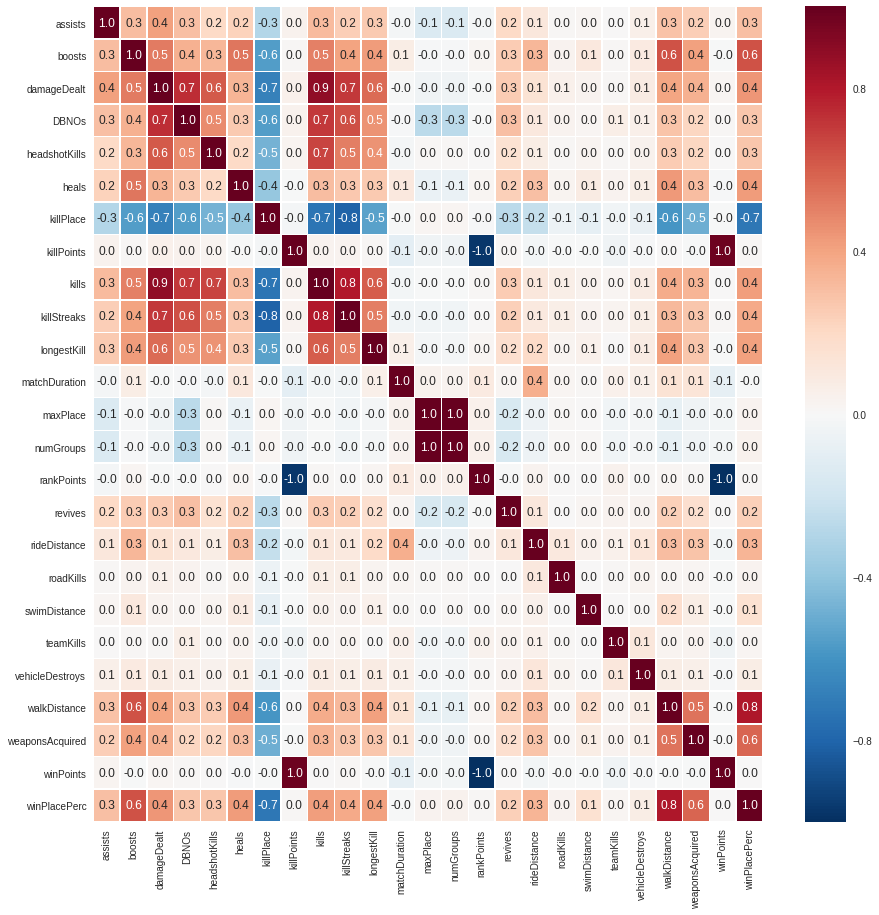

In [0]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

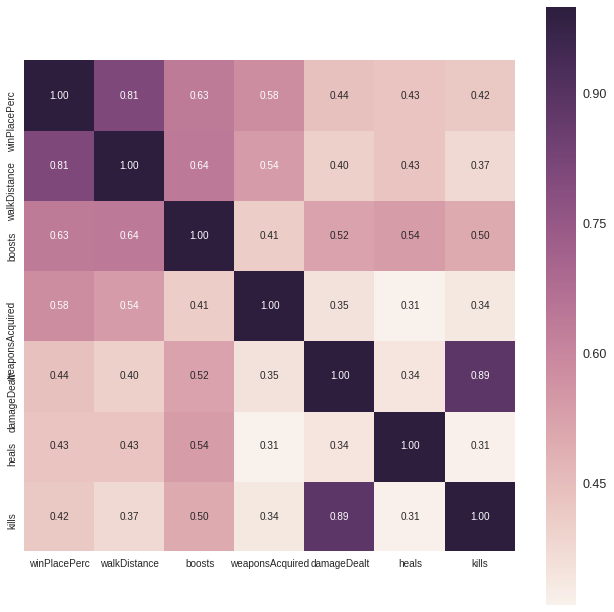

In [0]:
k = 7 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = df_train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#killers

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



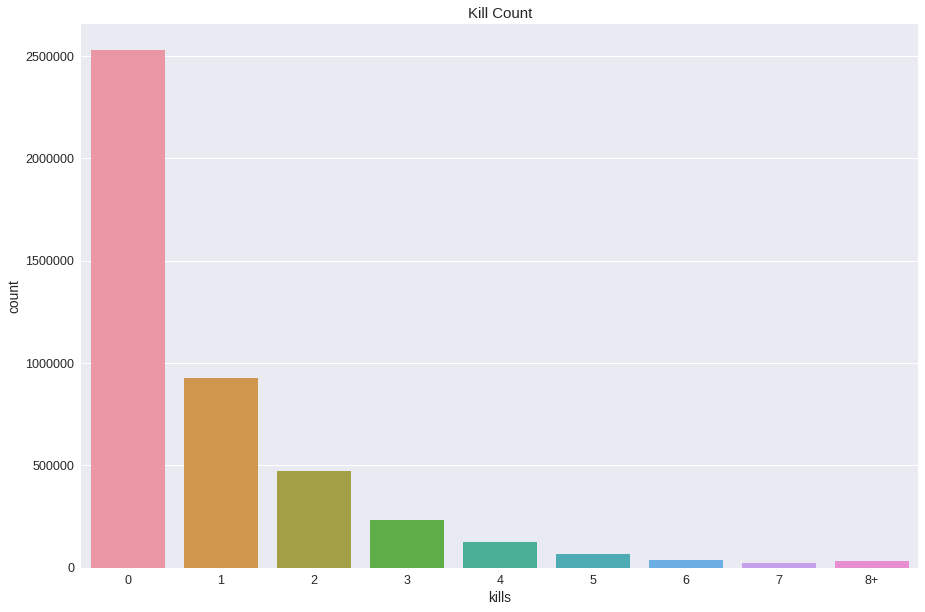

In [0]:
data = df_train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

#demageDealt

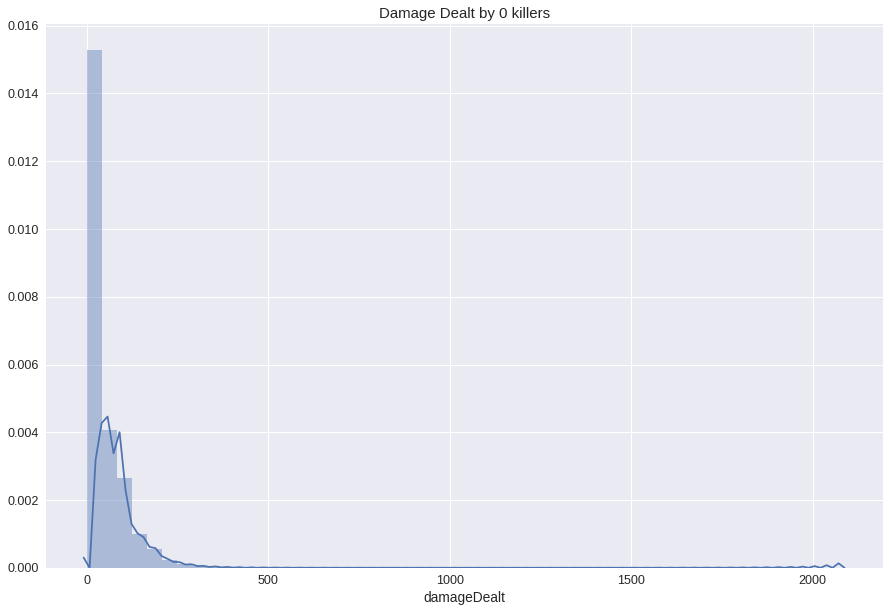

In [0]:
data = df_train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

#Plot win placement percentage vs kills.

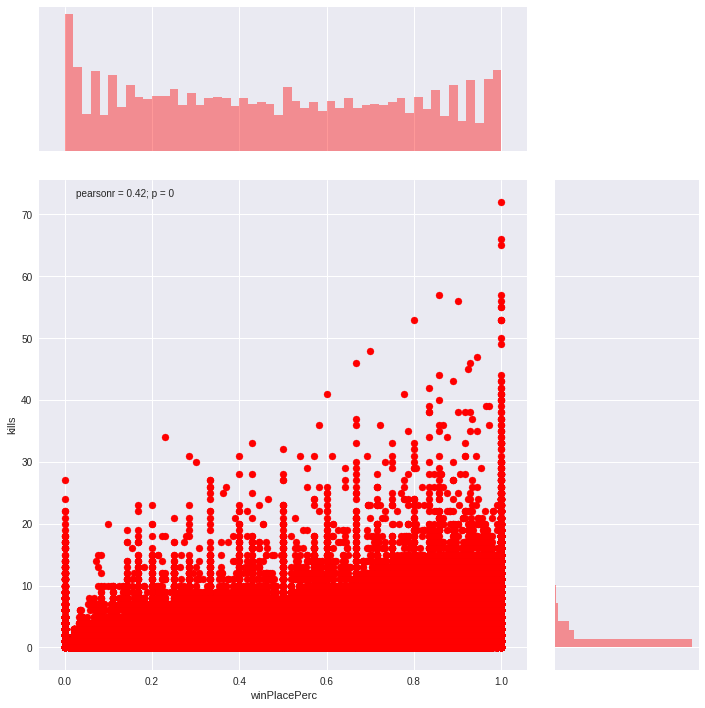

In [0]:
sns.jointplot(x="winPlacePerc", y="kills", data=df_train, size=10, ratio=3, color="r")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



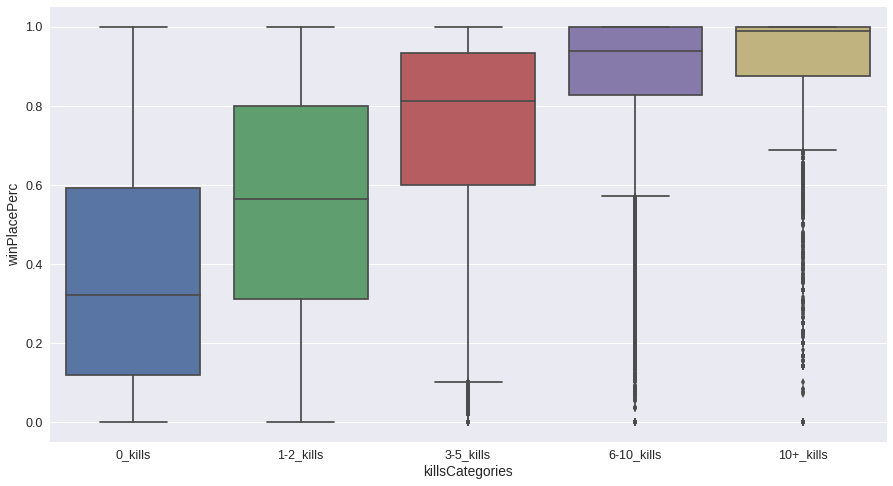

In [0]:
kills = df_train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

#walkDistance

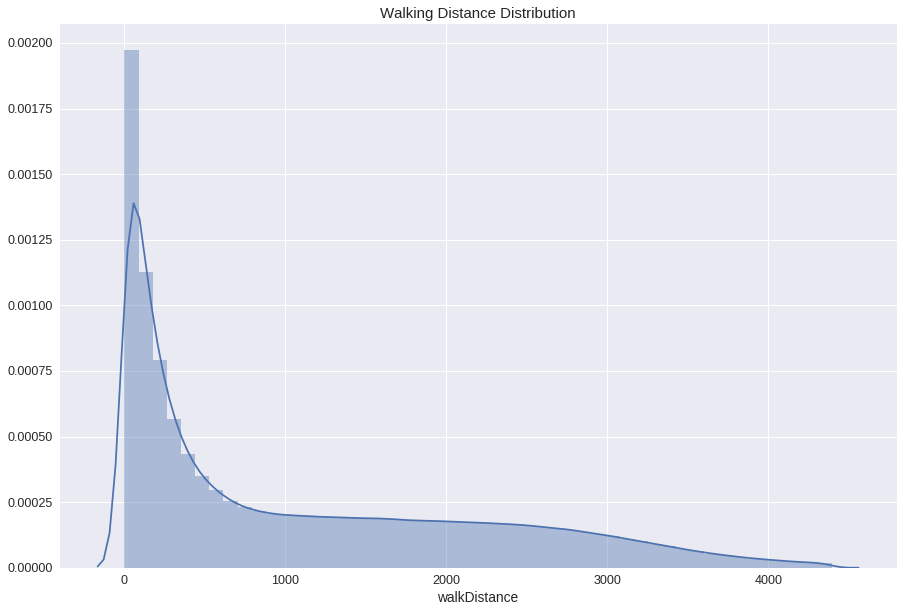

In [0]:
data = df_train.copy()
data = data[data['walkDistance'] < df_train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

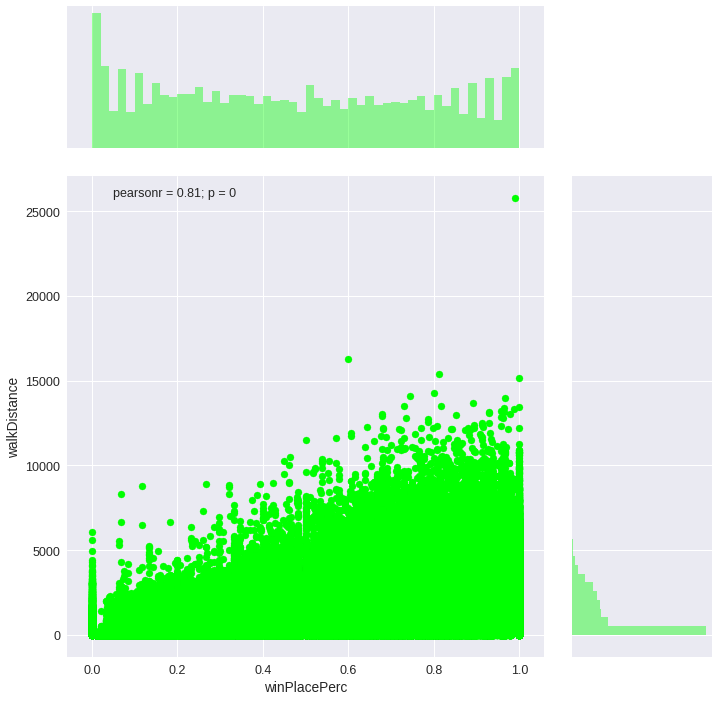

In [0]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=df_train, size=10, ratio=3, color="lime")
plt.show()

#heals vs boost

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



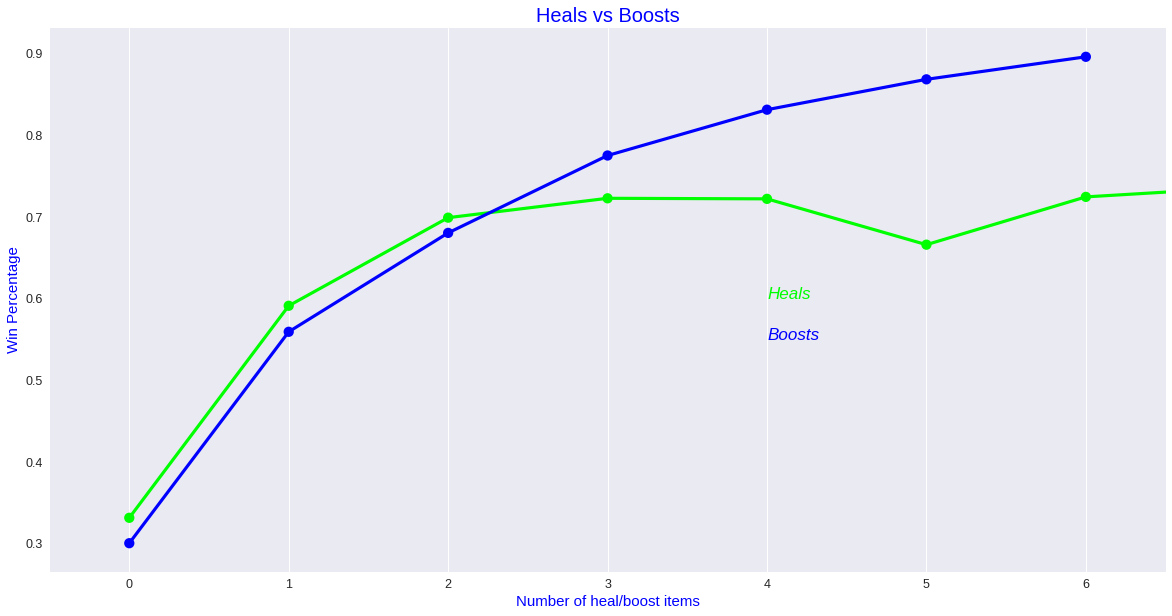

In [0]:
data = df_train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

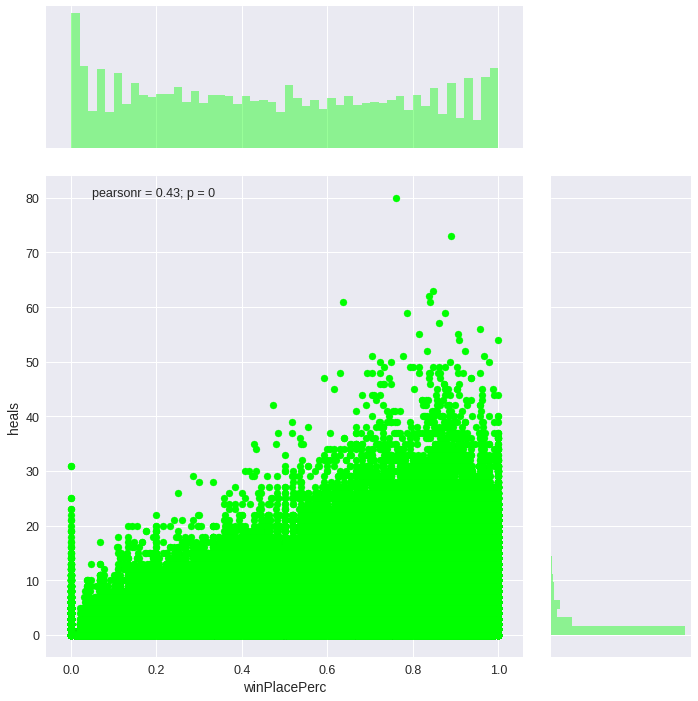

In [0]:
sns.jointplot(x="winPlacePerc", y="heals", data=df_train, size=10, ratio=3, color="lime")
plt.show()

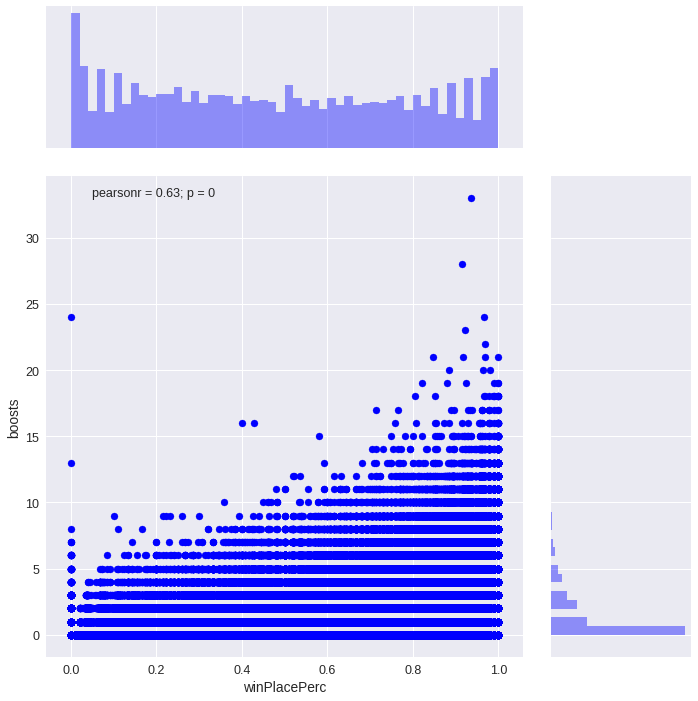

In [0]:
sns.jointplot(x="winPlacePerc", y="boosts", data=df_train, size=10, ratio=3, color="blue")
plt.show()

#Solos, Duos and Squads

In [0]:
solos = df_train[df_train['numGroups']>50]
duos = df_train[(df_train['numGroups']>25) & (df_train['numGroups']<=50)]
squads = df_train[df_train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(df_train), len(duos), 100*len(duos)/len(df_train), len(squads), 100*len(squads)/len(df_train),))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442528 (9.95%) squad games.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



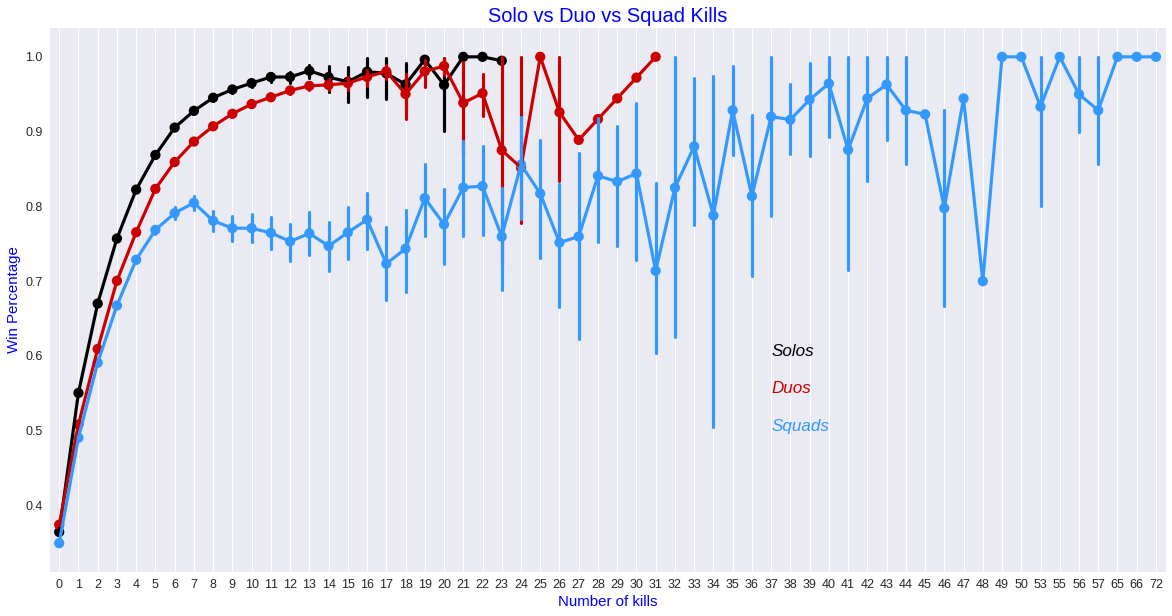

In [0]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



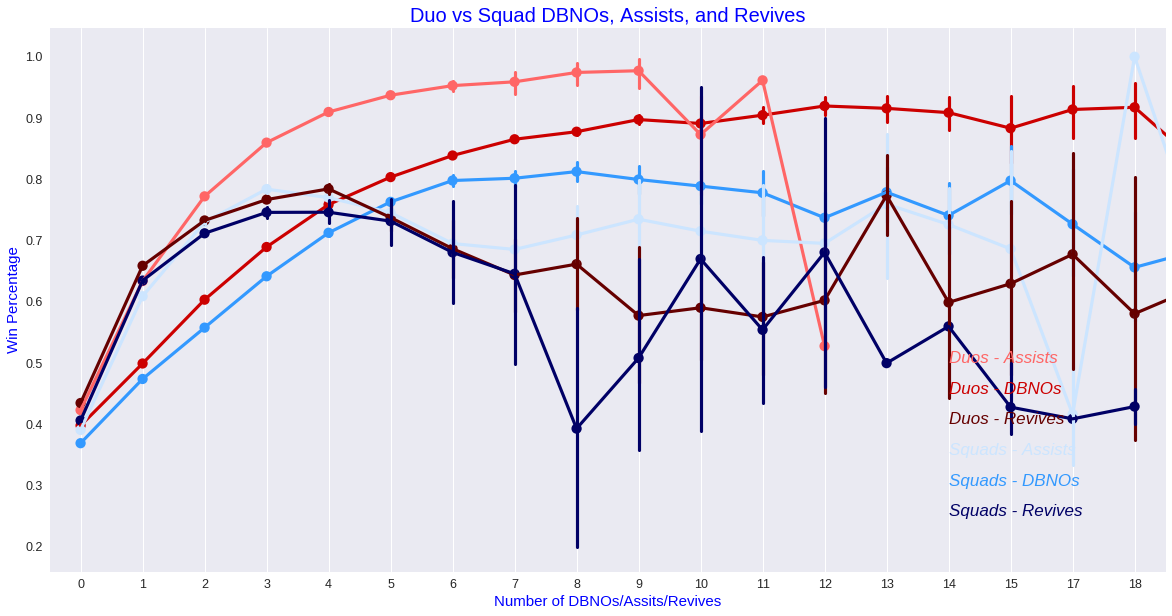

In [0]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

In [0]:
df = df_train[df_train.walkDistance != 0]
df = df[df.weaponsAcquired != 0]

In [40]:
df.shape

(4201430, 29)

In [0]:
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



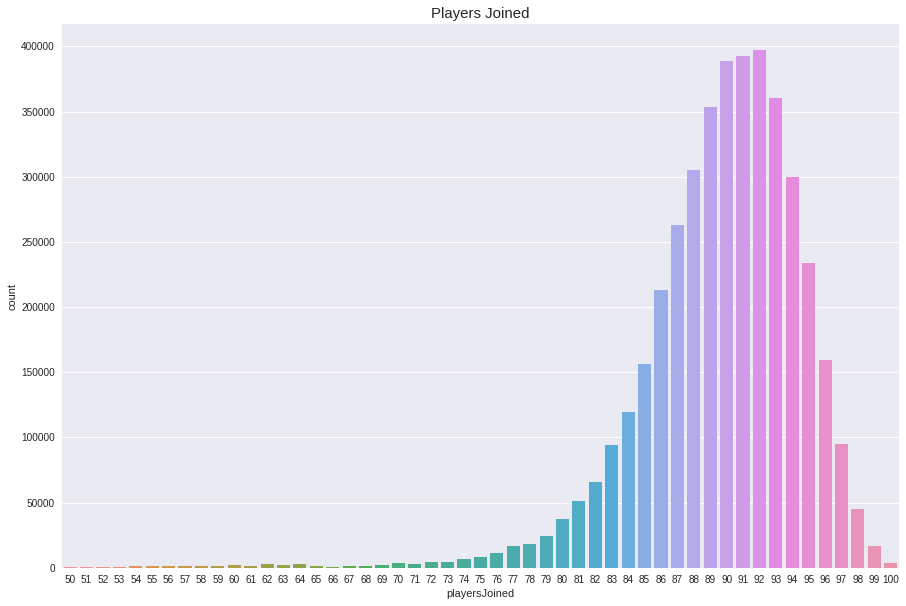

In [42]:
data = df.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [43]:
df = df[df.playersJoined > 49]
df.shape

(4182681, 30)

In [0]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn import metrics

In [44]:
features = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'DBNOs','longestKill','killStreaks','kills','heals','revives']
df = df[features]
df.head()

,winPlacePerc,walkDistance,boosts,weaponsAcquired,damageDealt,DBNOs,longestKill,killStreaks,kills,heals,revives
0,0.4444,244.80,0,1,0.00,0,0.00,0,0,0,0
1,0.6400,1434.00,0,5,91.47,0,0.00,0,0,0,0
2,0.7755,161.80,0,2,68.00,0,0.00,0,0,0,0
3,0.1667,202.70,0,3,32.90,0,0.00,0,0,0,0
4,0.1875,49.75,0,2,100.00,0,58.53,1,1,0,0


In [45]:
y = df['winPlacePerc']
sc = StandardScaler()
X = sc.fit_transform(df.drop(['winPlacePerc'], axis = 1))
X

array([[-0.8216407 , -0.671713  , -1.27287061, ..., -0.62992761,
        -0.52941215, -0.3605152 ],
       [ 0.18163203, -0.671713  ,  0.52366212, ..., -0.62992761,
        -0.52941215, -0.3605152 ],
       [-0.89166394, -0.671713  , -0.82373743, ..., -0.62992761,
        -0.52941215, -0.3605152 ],
       ...,
       [-0.36277757, -0.671713  ,  0.07452894, ..., -0.62992761,
        -0.52941215, -0.3605152 ],
       [ 1.29019271,  1.62291011,  1.87106166, ...,  0.67537191,
         0.20302461,  3.78646305],
       [ 0.02133787,  0.47559855,  0.52366212, ...,  0.67537191,
        -0.16319377, -0.3605152 ]])

In [46]:
y.head()

0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
Name: winPlacePerc, dtype: float64

In [47]:
y=y.reshape(-1,1)
y[y==1]=1
y[y<1]=0
y[:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)

In [50]:
rfr = RandomForestRegressor(n_jobs=-1)
rfr.fit(X_train, y_train)
rfr.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.06265796804760337

In [51]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9697388582792684

In [52]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9702532448008926

In [53]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.9506609142314811

In [1]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)
# RandomForest에 대한 confusion_matrix

NameError: ignored

In [0]:
from sklearn.metrics import mean_absolute_error

def print_score(m):
    res = [mean_absolute_error(m.predict(X_train), y_train), mean_absolute_error(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
print_score(rfr)

[0.01756346174667232, 0.04770580039240004, 0.8365577064967524, 0.07472586685526805]


In [0]:
y_pred = rfr.predict(X_test)

In [0]:
y_pred

array([0., 0., 0., 0., ..., 0., 0., 0., 0.])